In [4]:
import numpy as np
import os
import pandas as pd
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt
import random
import seaborn as sns
%matplotlib inline
from scipy.cluster.hierarchy import fcluster
import h5py
from io import StringIO
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
import itertools
import xlsxwriter as Excel

my project folder stores the downloaded data samples in a folder called **samples**

In [5]:
data_path = "samples"

In [6]:
#converts to df to binary dataframe, 0 representing that the previous value was 0, and 1 indicating a nonzero value
def df_to_binary(df_expression):    
    temp = df_expression
    num_rows = len(temp)
    for c in range(len(df_expression.columns)):
        nonzero_inds = df_expression.iloc[:,c].to_numpy().nonzero()[0]
        temp_col = np.zeros(num_rows)
        temp_col[nonzero_inds] = 1
        temp.iloc[:,c] = temp_col
    return(temp)



#INPUTS:
#  file_list: list of csv filenames containing expression data. Will concatenate these matrices together and compute distances
def preprocess_samples(file_list):
    sample_source = []
    # Merge all of the files into one dataframe
    df_expression = pd.read_csv(os.path.join(data_path,file_list[0]),index_col = 0,sep="\t")
    sample_source.extend(np.repeat(file_list[0],len(df_expression.columns)))
    for filename in file_list[1:]:
        temp = pd.read_csv(os.path.join(data_path,filename),index_col = 0, sep = "\t")
        sample_source.extend(np.repeat(filename,len(temp.columns)))
        df_expression = df_expression.merge(temp,right_index=True,left_index=True)
    
    df_expression.columns = pd.Series(df_expression.columns)
    df_expression.index = pd.Series(df_expression.index)
    
    return(df_expression,sample_source)    

In [7]:
file_list = ["ALPHA_expression.csv","beta_expression.csv","PANC1_expression.csv"]
df_expression_raw,sample_source = preprocess_samples(file_list)

In [8]:
df_expression_norm = (df_expression_raw - df_expression_raw.mean())/(df_expression_raw.std())

if you need to filter the data (define filter_to at bottom of last iteration once you have metadata):

In [165]:
#df_expression_raw = df_expression_raw.loc[["BRCA1","BRCA2","CHEK2", "RAD51", "BRIP1", "PALB2"],:]
#df_expression_norm = df_expression_norm.loc[["BRCA1","BRCA2","CHEK2", "RAD51", "BRIP1", "PALB2"],:]

transform the data (normalization and indication(x>0))

this cell takes a minute to run

In [123]:
df_expression_binary = df_to_binary(df_expression_raw)

In [8]:
#print("Sparsity Ratio = " + str(1-df_expression_binary.sum().sum()/(238522 * 35238)) )

# Cluster on Samples by gene arrays

To cluster samples on gene expressions, we have to transpose the data so that each sample is a row

In [166]:
method="average"
metric="euclidean"

In [167]:
#df_expression_trans = np.transpose(df_expression_raw)
df_expression_trans = np.transpose(df_expression_norm)
#df_expression_trans = np.transpose(df_expression_binary)

In [168]:
#dataTitle="Raw "
dataTitle=" Normalized "
#dataTitle=" Binary "

In [127]:
cluster_title = dataTitle +" Data (Filtered) Liver vs. HEPG2 cell "+method+"+"+metric

In [169]:
def hierarchical_clustering(df,title,method="average",metric="euclidean"):
    clustering = shc.linkage(df, method=method, metric=metric)
    plt.figure(figsize=(25, 20))  
    plt.title(title)  

    dend = shc.dendrogram(clustering) 
    print("Cophenet = " + str(cophenet(clustering, pdist(df))[0]))
    return(clustering)

Here I try three different combinations of input data and metric. 
### TODO: Use the below code to explore and analyze other combinations by comparing their cophenet and purity. Explore other methods besides "average". Best thing to do is adjust one hyperparameter at a time, leaving all else fixed. Remember that the input data itself is a hyperparameter because we have three options (1. raw 2. normalized 3. binary). Don't forget we also have much more data than ovarian data, so we may need to split this work later on

The closer the cophenet score is to 1, the better the clustering

Cophenet = 0.9213235726198434


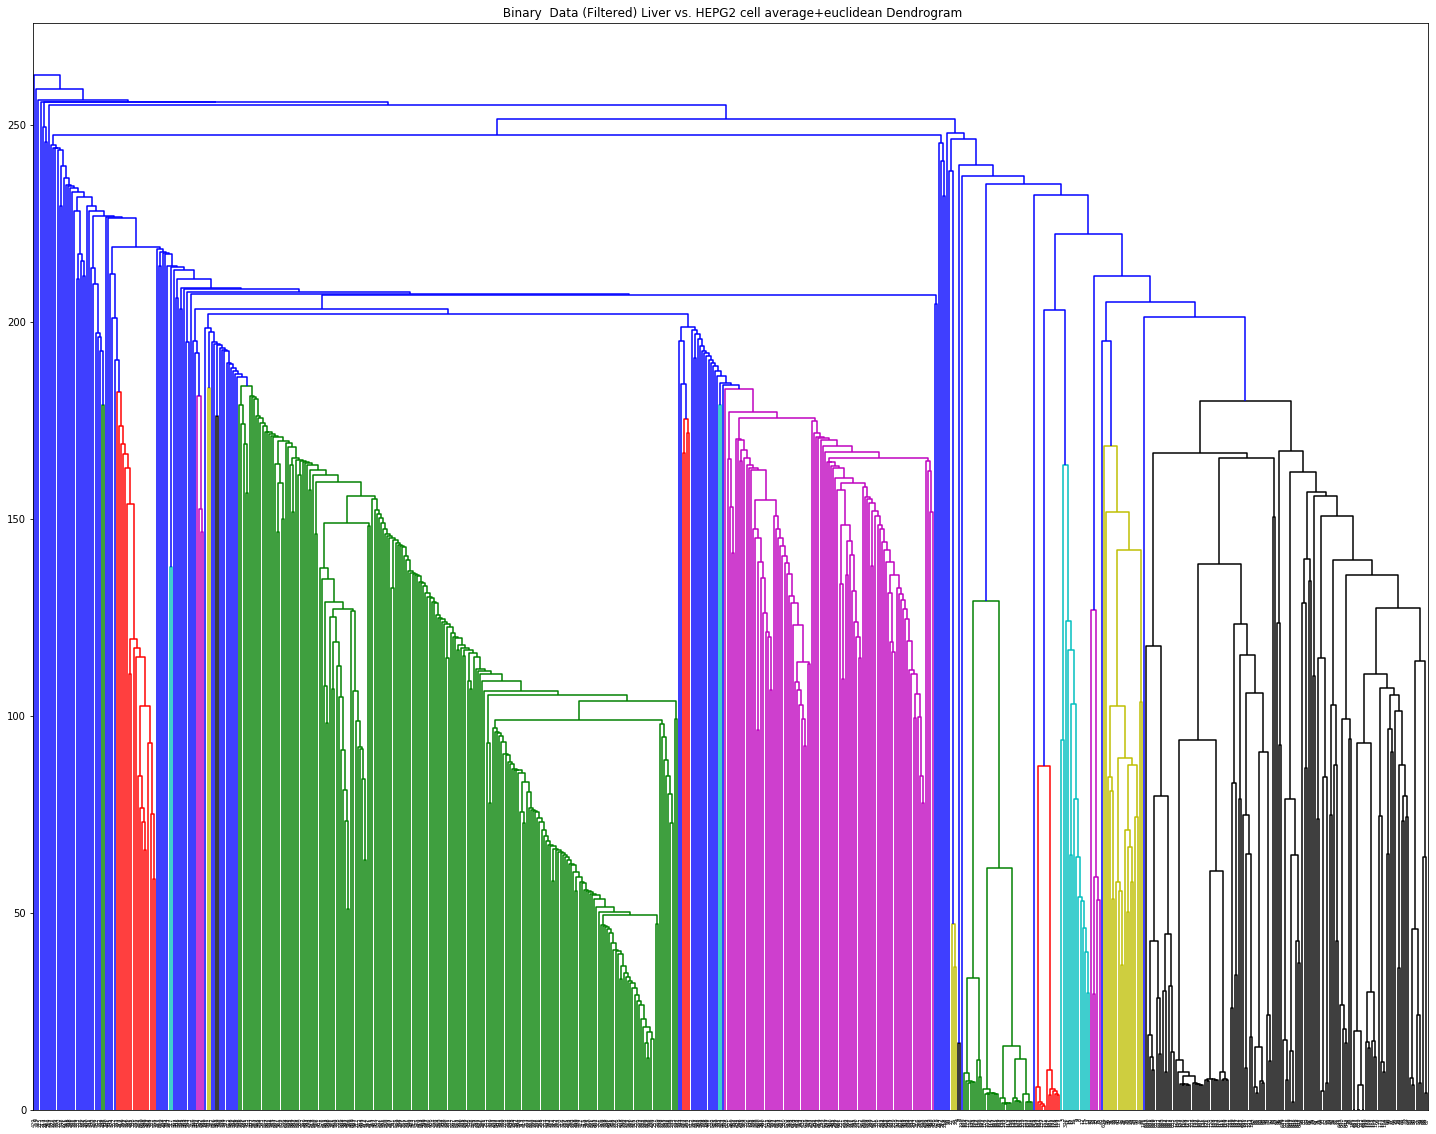

In [170]:
clustering = hierarchical_clustering(df_expression_trans, method=method, metric=metric, title = cluster_title + " Dendrogram")

Use  your eyeballs to come up with an appropriate number of clusters to analyze. I am going to choose the first dendogram because it is obvious that k=3

In [171]:
k = 3
cluster_assignments = fcluster(clustering, k, criterion='maxclust')
cluster_assignments

array([2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

Cluster Assessment Helper Functions

In [172]:
#INPUTS: 
#  h5filepath: path where the full matrix is stored with meta and expression data
#  subsamples: a pandas DataFrame that must contain a column (foreign key) called SampleGeoAccession
#OUTPUT
#  merged dataframe of length(subsamples) merged with relevant meta/Sample values for cluster analysis
def h5_sample_meta_lookup(h5filepath,subsamples):
    f = h5py.File(h5filepath, 'r')
    full_data = pd.DataFrame({"Description":f[("meta/Sample_description")], 
                          "Characteristics":f[("meta/Sample_characteristics_ch1")],
                          "SampleGeoAccession":f[("meta/Sample_geo_accession")],
                          "Series ID":f[("meta/Sample_series_id")],
                          "Molecule":f["meta/Sample_molecule_ch1"],
                          "Source Name":f["meta/Sample_title"]})
    f.close()
    full_data["SampleGeoAccession"] = full_data["SampleGeoAccession"].apply(lambda x : x.decode("utf-8"))
    cluster_meta = subsamples.merge(full_data,on="SampleGeoAccession",how="left")
    cluster_meta["Sample_Label"] = pd.Series(sample_source).str.replace(".csv","").str.replace("_expression"," ")
    cluster_meta["Series ID"] = cluster_meta["Series ID"].str.decode("utf-8").str.replace("Xx","").str.replace("xX","")
    cluster_meta["Molecule"] = cluster_meta["Molecule"].str.decode("utf-8")
    cluster_meta["Source Name"] = cluster_meta["Source Name"].str.decode("utf-8")
    cluster_meta["Description"] = cluster_meta["Description"].str.decode("utf-8").str.replace("Xx","").str.replace("xX","")
    cluster_meta["Characteristics"] = cluster_meta["Characteristics"].str.decode("utf-8").str.replace("Xx","").str.replace("xX","")
    return(cluster_meta)

Merge cluster assignments data with corresponding metadata

In [173]:
cluster_dict = {"SampleGeoAccession":[],"ClusterAssignment":[]}
cluster_dict["SampleGeoAccession"] = df_expression_trans.index
cluster_dict["ClusterAssignment"] = cluster_assignments
cluster_info = pd.DataFrame(cluster_dict)
cluster_metadata = h5_sample_meta_lookup("human_matrix.h5",cluster_info).sort_values("ClusterAssignment")

Use this dataframe to assess the clustering based on 1. Bootstrapping. 2. Purity/Efficiency

Here is the purity efficiency calculations

In [174]:
cluster_metadata_metrics = {}
for c in range(1,k+1):
    cluster_metadata_metrics[c] = {"Size":len(cluster_metadata.loc[cluster_metadata.ClusterAssignment == c]), 
                                   "Molecule Purity":{},"Series Purity":{},"Label Purity":{}}
    series_counts = cluster_metadata.groupby('ClusterAssignment')["Series ID"].value_counts()
    molecule_counts = cluster_metadata.groupby('ClusterAssignment')["Molecule"].value_counts()
    label_counts = cluster_metadata.groupby('ClusterAssignment')["Sample_Label"].value_counts()
    
    series_purity_key = pd.Series(series_counts[c][series_counts[c] == series_counts[c].max()]).index[0]
    series_purity_val = series_counts[c].max()/float(series_counts[c].sum())
    cluster_metadata_metrics[c]["Series Purity"][series_purity_key] = round(series_purity_val,3)

    molecule_purity_key = molecule_counts[c][molecule_counts[c] == molecule_counts[c].max()].index[0]
    molecule_purity_val = molecule_counts[c].max()/float(molecule_counts[c].sum())
    cluster_metadata_metrics[c]["Molecule Purity"][molecule_purity_key] = round(molecule_purity_val,3)
    
    label_purity_key = label_counts[c][label_counts[c] == label_counts[c].max()].index[0]
    label_purity_val = label_counts[c].max()/float(label_counts[c].sum())
    cluster_metadata_metrics[c]["Label Purity"][label_purity_key] = round(label_purity_val,3)
    
    

In [175]:
cluster_metadata_metrics

{1: {'Size': 658,
  'Molecule Purity': {'total RNA': 0.944},
  'Series Purity': {'GSE87849': 0.657},
  'Label Purity': {'ES2 ': 0.851}},
 2: {'Size': 1,
  'Molecule Purity': {'polyA RNA': 1.0},
  'Series Purity': {'GSE30017': 1.0},
  'Label Purity': {'Ovary ': 1.0}},
 3: {'Size': 1,
  'Molecule Purity': {'total RNA': 1.0},
  'Series Purity': {'GSE87849': 1.0},
  'Label Purity': {'ES2 ': 1.0}}}

In [176]:
def purity_to_excel(cluster_metadata_metrics, outfile):
    workbook = Excel.Workbook("tables/" +outfile +".xlsx")
    worksheet = workbook.add_worksheet()
    cluster_format = workbook.add_format({'bold': True, 'align':'center'})
    center = workbook.add_format({'align': 'center'})

    # Add a format. Light red fill with dark red text.
    format1 = workbook.add_format({'bg_color': '#FFC7CE',
                                   'font_color': '#9C0006'})

    # Add a format. Green fill with dark green text.
    format2 = workbook.add_format({'bg_color': '#C6EFCE',
                                   'font_color': '#006100'})

    worksheet.write('A1', "Cluster ID",cluster_format)
    worksheet.write('B1', "Cluster Size",center)
    worksheet.write('C1', "Dominant Molecule",center)
    worksheet.write('D1', "Molecule Purity",center)
    worksheet.write('E1', "Dominant Series",center)
    worksheet.write('F1', "Series Purity",center)
    worksheet.write('G1', "Dominant Label",center)
    worksheet.write('H1', "Label Purity",center)

    worksheet.set_column(1, 7, 15)

    num_keys = len(list(cluster_metadata_metrics.keys()))

    j = 1
    for i in np.sort(list(cluster_metadata_metrics.keys())):
        worksheet.write(j,0,i,center)
        worksheet.write(j,1,cluster_metadata_metrics[i]["Size"],center)
        worksheet.write(j,2,list(cluster_metadata_metrics[i]["Molecule Purity"].keys())[0],center)
        worksheet.write(j,3,list(cluster_metadata_metrics[i]["Molecule Purity"].values())[0],center)
        worksheet.write(j,4,list(cluster_metadata_metrics[i]["Series Purity"].keys())[0],center)
        worksheet.write(j,5,list(cluster_metadata_metrics[i]["Series Purity"].values())[0],center)
        worksheet.write(j,6,list(cluster_metadata_metrics[i]["Label Purity"].keys())[0],center)
        worksheet.write(j,7,list(cluster_metadata_metrics[i]["Label Purity"].values())[0],center)
        
        j += 1

    # Write a conditional format over a range.
    worksheet.conditional_format('H2:H'+str(num_keys+1), {'type': 'cell',
                                             'criteria': '>=',
                                             'value': 0.8,
                                             'format': format2})

    # Write another conditional format over the same range.
    worksheet.conditional_format('H2:H'+str(num_keys+1), {'type': 'cell',
                                             'criteria': '<',
                                             'value': 0.8,
                                             'format': format1})



    workbook.close()

In [177]:
purity_to_excel(cluster_metadata_metrics,cluster_title+" purity")

Keep in mind we expect to see high purity for total RNA because the majority of samples use total RNA

Interesting thing to note about this clustering:

- Cluster 1 has poor label purity (why are ovarian and ES2 samples getting grouped together here? Most of the polyA RNA samples (except for one) ended up in this group as well.
- Cluster 2 contains all samples from the same series (GSE87849)
- Cluster 3 contains two samples, both ovary, two different series. 

Let's investigate what the two samples in cluster 3 have in commmon


In [ ]:
np.unique(cluster_metadata["Series ID"])

In [ ]:
cluster_metadata.loc[cluster_metadata["Series ID"] == "GSE97655",:].loc[cluster_metadata["ClusterAssignment"] == 2]

In [137]:
series_counts = cluster_metadata["Series ID"].value_counts()

In [40]:
filter_to = []
for d in range(len(cluster_metadata["Series ID"])):
    if series_counts[cluster_metadata["Series ID"].iloc[d]] > 4:
        filter_to.append(cluster_metadata["SampleGeoAccession"].iloc[d])

In [ ]:
filter_to = list(cluster_metadata.loc[cluster_metadata["Series ID"] != 'GSE87849' ,"SampleGeoAccession"])

Use this URL to investigate samples or series:

https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM2343109	
https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM742947	

The first sample seems to come from a non-coding RNA profile (and is a solo sample in its series) which can explain why it is so different from the rest of the samples

The second sample seems to come from a special series exploring alternative splicing where tissues from 16 different parts of the human body were spliced, the ovary being one. 

# TODO: Build a function to assess each clustering method with bootstrap validation. (Optional Bonus: group the purity code I have above into functions)

In [138]:
clusters = {}
for v in range(len(cluster_dict["ClusterAssignment"])):
    if cluster_dict["ClusterAssignment"][v] not in clusters:
        clusters[cluster_dict["ClusterAssignment"][v]] = []
    clusters[cluster_dict["ClusterAssignment"][v]].append(cluster_dict["SampleGeoAccession"][v])

In [178]:
import time

# function calculate the jaccard coefficient of two vectors, return values
def jaccard(a,b):
    #print(a)
    #print(b)
    c = set(a).intersection(set(b))
    jacc = float(len(set(c))) / (len(set(a)) + len(set(b)) - len(set(c)))
    #print(jacc)
    return(jacc)

# function that resample a given dataset, return new dataset
def resample(df):
    df_new = df
    allelements = []
    for i in range(len(df.index)):
        for j in range(len(df.columns)):
            allelements.append(df.iat[i,j])
    for x in range(len(df.index)):
        for y in range(len(df.columns)):
            df_new.iat[x,y] = random.choice(allelements)
    return (df_new)

# Hi Alex, I think maybe returning a list of original clusters which dissovled too often 
# is more reasonable than returning a data structure according to your description of this function? 
def hierarchical_bootstrap_validation(df,k, method='average',metric='sqeuclidean',n_bootstraps=100):
    x = shc.linkage(df,method=method,metric=metric)
    # the list of original clusters 
    cluster_assignments_x = fcluster(x, k, criterion='maxclust')

    xxs = {"SampleGeoAccession":[],"ClusterAssignment":[]}
    xxs["SampleGeoAccession"] = df.index
    xxs["ClusterAssignment"] = cluster_assignments_x
    xx = {}
    for v in range(len(xxs["ClusterAssignment"])):
        if xxs["ClusterAssignment"][v] not in xx:
            xx[xxs["ClusterAssignment"][v]] = []
        xx[xxs["ClusterAssignment"][v]].append(xxs["SampleGeoAccession"][v])
        
    # record the list of list1
    list2 = []
    for i in range(n_bootstraps):
        #new_df = resample(df)
        new_df = df.sample(len(df),replace=True)
        y = shc.linkage(new_df,method=method,metric=metric)
        # the list of new clusters
        cluster_assignments_y = fcluster(y, k, criterion='maxclust')
        yys = {"SampleGeoAccession":[],"ClusterAssignment":[]}
        yys["SampleGeoAccession"] = df.index
        yys["ClusterAssignment"] = cluster_assignments_x
        yy = {}
        for v in range(len(yys["ClusterAssignment"])):
            if yys["ClusterAssignment"][v] not in yy:
                yy[yys["ClusterAssignment"][v]] = []
            yy[yys["ClusterAssignment"][v]].append(yys["SampleGeoAccession"][v])
                    
        # record the max jaccard coefficient of each original clusters 

        list1 = []
            
        for j in xx:
            max_Jc = 0
            for h in yy:
                Jc = jaccard(xx[j],yy[h])
                if Jc >= max_Jc:
                    max_Jc = Jc
            list1.append(max_Jc)
        list2.append(list1)
            
    # record the original cluster that dissolved too often
    list3 = []
    for u in range(len(np.unique(xx))):
        z = 0
        for v in range(n_bootstraps):
            if list2[v][u] < 0.6:
                z += 1
        # justify if dissovled too often
        if z>= (len(xx)/2):
            list3.append(xx[u])
    return (list2,list3)

In [179]:
hierarchical_bootstrap_validation(df_expression_trans,k, method,metric,100)

([[1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0],
  [1.0, 1.0,

# TODO: Finish Clustering on Samples by gene profiles by replicating what I have above (except don't take the transpose of the expression datafram). Find out optimal way of clustering on as many genes as possible (Below, I only use 100 genes via random sampling. Maybe choose best genes based on regression techniques)

## But first, find subset of genes with most counts so we don't overload visualization?

In [ ]:
df_expression_raw["gene_sum"] = df_expression_raw.sum(axis=1)


In [ ]:
df_expression_raw.gene_sum

In [ ]:
df_expression_sorted = df_expression_raw.sort_values("gene_sum",ascending=False)
plt.hist(df_expression_sorted.gene_sum)


Let's pick genes with over 600 

In [ ]:
df_expression_raw_subset = df_expression_raw.loc[df_expression_raw.gene_sum > 600,:]
print(len(df_expression_raw_subset))

IF NECESSARY: Further decrease the sample space by random sampling N(=100) genes

In [ ]:
df_expression_raw_sample = df_expression_raw_subset.sample(100)

In [ ]:
clustering_norm_avg = hierarchical_clustering(df_expression_raw_sample, method='average', metric="sqeuclidean")

Need to find a way to make heatmap more informative. Notice bright colors on the corners

In [ ]:
df_expression_raw_sample

Visualization Heatmap